<a href="https://colab.research.google.com/github/andersknudby/Remote-Sensing/blob/master/GEE%20Lab%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GEE Lab 2: Indices, Compositing, and Mosaicking in Google Earth Engine
Developed by Genevieve George


## Introduction

In this lab we will continue working with the Google Earth Engine python API in Google Colab. 
We will learn how to calculate multi-spectral indices, and how to create composites and mosaic imagery.

**Files you need:** N/A

**Preparation:** Just keep up with the readings!

## Steps

###| 1. Imports, installation, authentication, initialization

Our first step is to get the notebook set up. Review the description in the first lab if you want a refresher on why we need to do this, and remember that you may get some warnings that you can ignore.


In [ ]:
# Install geemap library so that we can use it to view images on an interactive map
## You may get a runtime warning - you can ignore that
!pip install geemap

In [ ]:
# Import the necessary libraries
import ee
import numpy as np
import geemap as geemap
import pprint

# Set up a 'pretty printer' to print ...
pp = pprint.PrettyPrinter(depth=3)

In [ ]:
# Authenticate and initialize this instance of GEE in Google Colab
## Follow the prompts and fill in authentication code
ee.Authenticate()
ee.Initialize()

### | 2. Indices

#### Multispectral indices are calculated using simple **band math**. Recall that the Normalized Difference Vegetation Index (NDVI) is:

```
(NIR - RED) / (NIR + RED)
```
We can calculate any multi-spectral index as long as we are using a sensor that  has the bands we need. For example, we can easily calculate NDVI for Landsat 8, where Band 5 is the NIR band and Band 4 is the Red band:

```
NDVI = image.select('B5').subtract(image.select('B4')) 
          .divide(image.select('B5').add(image.select('B4')))
```

The `image.subtract(image2)`, `image.add(image2)`, and `image.divide(image2)` are all math functions that operate on two images. They are the equivalent of:

`image - image2`

`image + image2`

`image / image2`

These image math functions can be used to do any kind of band math you need to calculate a given index, or to calculate other kinds of band relationships.

The `image.select()` function selects specified bands for an image as either a single band as with `image.select('B5')` or a list of bands like `image.select(['B5','B4'])`. Note that when you want to select multiple bands, you need to put them in a list with square brackets.

By using `image.select(Band)`, we are making sure the raster math is done only with the bands we want to use within *the same image*, rather than with every band in two different images.


####However, GEE also has a built in **“normalized difference”** function that saves several lines of code
```
NDVI = normalizedDifference('B5','B4')
```
This is a great way to calculate common normalized difference functions, but if you need to calculate other kinds of indices, you will still need to use the generic band math method.

Let's try both of them out and visualize their outcomes. 

In [ ]:
# First, import the Landsat 8 Tier 1 surface reflectance as a variable
l8SR = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

# Create a point at Alfred Bog (east of Ottawa)
point = ee.Geometry.Point([-74.8588,45.4839]) 

# Filter for images within our date range that overlap our point
# sort by cloud cover and choose least cloudy (first)
l8SR_Jul2019_LC = l8SR.filterBounds(point) \
                      .filterDate('2020-08-01', '2020-08-31') \
                      .sort('CLOUD_COVER') \
                      .first()


Now that we have our image in the variable `l8SR_Jul2019_LC`, lets calculate NDVI both manually and using the normalized difference function.

While working with an index that will be stored in a single band, we will want to use different visualization parameters than we have used so far with our multispectral images. 

The [GEE Documentation](https://developers.google.com/earth-engine/tutorials/tutorial_api_02) describes their colours as follows: 

"The colors are defined using the web standard CSS color value scheme. Colors can be specified by name or as hexadecimal strings indicating the combination of red, green and blue. The lowest value in any of the three positions is 00 (representing the decimal number 0), while the highest is FF (representing the decimal number 255). The string '000000' represents the color black, 'FFFFFF' is white, 'FF0000' is red, '00FF00' is green, and '0000FF' is blue."

See the [GEE page](https://developers.google.com/earth-engine/guides/image_visualization#color-palettes) on color palettes for more information.

Also check out this [Google color picker tool](https://www.google.com/search?q=color+picker) which can be helpful when choosing your own palettes and colour schemes by hex#.



In [ ]:
# Compute NDVI the manual way!
NDVI_long = l8SR_Jul2019_LC.select('B5').subtract(l8SR_Jul2019_LC.select('B4')) \
               .divide(l8SR_Jul2019_LC.select('B5').add(l8SR_Jul2019_LC.select('B4')))

#Using the Normalized difference function
# note: The band is renamed to 'ndvi' as default is to add a band called 'nd' to the image
NDVI = l8SR_Jul2019_LC.normalizedDifference(['B5', 'B4']).rename('ndvi'); 




In both methods, we create a new image in a new variable that contains **just** the ndvi band that we created. 

Let's check out the band names of both images to better understand the differences. 

The code `image.get()` gets the metaproperties of the image (in this case, we are interested in the property `system:band_names` which is the property that stores the name of the bands)

In [ ]:
print('NDVI_long Bands:\n',NDVI_long.get('system:band_names').getInfo())

print('NDVI Bands:\n',NDVI.get('system:band_names').getInfo())


In the long method, the band is called 'B5' because that is the band name that we selected from the original image and then did our calculations on. We could rename it if we want (in the same way we did for the normalized difference function) to make sure we keep track of what bands are what.

Now let's visualize our NDVI indices, as well as the true colour image.

In [ ]:
Map = geemap.Map()

# Set the L8 true colour vis params
L8_TC_vis = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000,
  'gamma': 1.4,
}

# Recall that NDVI is a value between -1 and 1
# We set the min in this case as 0.25 to better show the difference in our area
# Feel free to play around and change the min to 0
# The palette here are colours between white (FFFFFF) and green (006400)
NDVI_vis = {'min': 0.25, 'max': 1, 'palette': ['FFFFFF', '006400']}

Map.addLayer(l8SR_Jul2019_LC,L8_TC_vis,'l8SR_Jul2019_LC')
Map.addLayer(NDVI_long, NDVI_vis, 'NDVI_long')
Map.addLayer(NDVI, NDVI_vis, 'NDVI')
Map.addLayerControl()
Map.centerObject(point,8)

Map

Both of them create the exact same map - which is good! That is what we expect.

Now let's try a couple of other indices.
*   Normalized Difference Water Index (NDWI)
*   Normalized Difference Built-up Index (NDBI)
*   Enhanced Vegetation Index (EVI)
*   Built-up Index (BUI)
*   Enhanced Vegetation Index (BAI)

As we go, we will create a unique palette for each index that makes sense for what it is showing (e.g., greens for vegetation, blues for water, etc.)

In [ ]:
#NDWI = (GREEN – NIR) / (GREEN + NIR)
NDWI = l8SR_Jul2019_LC.normalizedDifference(['B3', 'B5']).rename('ndwi')
NDWI_vis = {'min': -1, 'max': 1, 'palette': ['00FFFF', '0000FF']}

In [ ]:
#NDBI = (SWIR – NIR) / (SWIR + NIR)
NDBI = l8SR_Jul2019_LC.normalizedDifference(['B6', 'B5']).rename('ndbi')
NDBI_vis = {'min': -1, 'max': 1, 'palette': ['1ee6dc', 'ff2b3d']}

In [ ]:
#BUI = NDBI - NDVI
BUI = NDBI.select('ndbi').subtract(NDVI.select('ndvi'))
BUI_vis = {'min': -1, 'max': 1, 'palette': ['1ee6dc', 'ff2b3d']}

You can also create bands using a mathematical expression. In this method, the expression is written as a string where any variables can be defined as a second argument in the function. Check out the example below with the Enhanced Vegetation Index (EVI).

In [ ]:
#EVI = 2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))
EVI = l8SR_Jul2019_LC.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
      'NIR': l8SR_Jul2019_LC.select('B5'),
      'RED': l8SR_Jul2019_LC.select('B4'),
      'BLUE': l8SR_Jul2019_LC.select('B2')
})
EVI_vis = {'min': -1, 'max': 1, 'palette': ['FFFFFF', '006400']}

Now add all they layers to the map and see what they look like.

In [ ]:
Map = geemap.Map()

Map.addLayer(NDVI, NDVI_vis, 'NDVI')
Map.addLayer(NDWI, NDWI_vis, 'NDWI')
Map.addLayer(NDBI, NDBI_vis, 'NDBI')
Map.addLayer(BUI, BUI_vis, 'BUI')
Map.addLayer(EVI, EVI_vis, 'EVI')

Map.addLayerControl()
Map.centerObject(point,8)

Map

###| 3. Compositing

Compositing in Google Earth Engine is based on the process of 'reducing'. Reducers are a way to aggregate data over time, space, bands, etc. in GEE. 

If you have taken any other GIS/geomatics classes, you are probably familiar with the concept of zonal statistics, where the values of a raster are summarized into statistics (like mean, median, max, min, etc.) based on a 'zone' defined by either a polygon or another raster.

Zonal statistics are an example of a spatial reduction, where values across an area are aggregated (summed, averaged, etc.), but reducers can also be used to summarize images and image collections temporally. This works by calculating a statistic based on a stack of overlapping pixels (say a stack of images from every day in July) to calculate a summary statistic (average surface reflectance in July) for each pixel in the image.



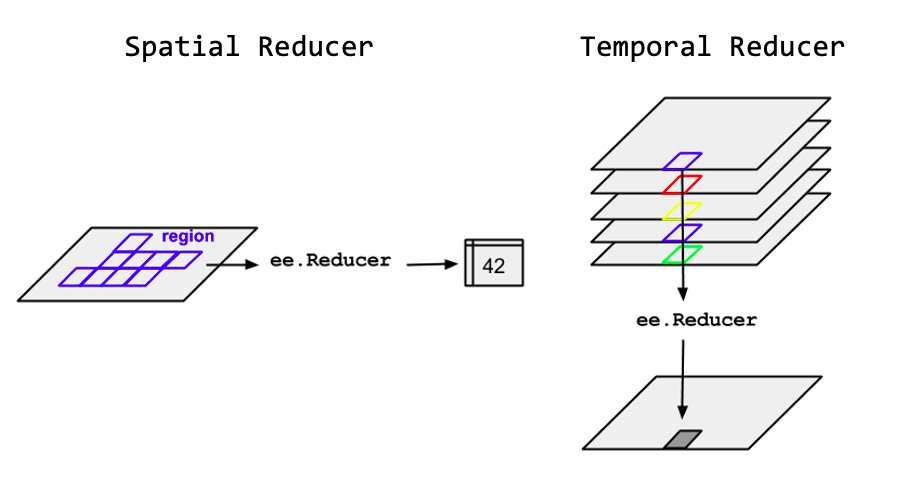


For this lab, we will concentrate on using temporal reducers to aggregate a series of images. One of the major strengths of Google Earth Engine is its ability to easily and quickly process huge amounts of information (like a series of images).


#### Landsat 8 Cloud Free Composite

We will create a Landsat 8 cloud-free summer composite. By creating an image composite rather than just cloud masking an image, it enables us to have a seamless cloud-free base for future analyses or visualization.

To get a better idea of how this works, we will plot both the least cloudy image from Summer 2019 and the composite image from 2019.

For this example we will use the median as our reducer. So, for each pixel in the image stack, the median pixel value will be used in the composite image.

In [ ]:
# Assign Landsat 8 Surface Reflectance Image Collection to a variable

L8_SR_T1 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")

In [ ]:
# Define cloud masking function (same as last lab)

def cloudMaskL8(image):
  # Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloudShadowBitMask = 1 << 3 #select the cloud shadow bit location
  cloudsBitMask = 1 << 5 # select the cloud bit location
  # Get the pixel QA band.
  qa = image.select('pixel_qa')
  # Both flags should be set to zero, indicating clear conditions.
  # this only keeps pixels were both the cloud and cloud shadow bits are set to 0
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(qa.bitwiseAnd(cloudsBitMask).eq(0))
  # Return the masked image, not scaled to reflectance, with the QA bands.
  return image.updateMask(mask)

Next, lets filter the image collection. Instead of using a geometry (point or polygon) to filter our image collection, this time we will use the path and row to ensure we are using images that are right on top of each other. All Landsat scenes cover one path/row combination, and path 15 / row 29 correspond to a scene covering the area south and east of Ottawa.

In [ ]:
# Filter the collection and apply the cloud mask
L8_Ottawa = L8_SR_T1.filterDate('2019-06-01', '2019-08-31')\
                        .filter(ee.Filter.eq('WRS_PATH', 15))\
                        .filter(ee.Filter.eq('WRS_ROW', 29))\
                        .map(cloudMaskL8)

In [ ]:
# create a variable for the least cloudy image
L8_Ottawa_LC = L8_Ottawa.sort('CLOUD_COVER').first()

# Create the median composite
L8_Ottawa_median = L8_Ottawa.reduce(ee.Reducer.median())

Now that we have both the least cloud image, and the composite image, let's plot them to see how they turned out

In [ ]:
# Note that when we reduced the image collection, the bands got renamed to add '_median' at the end
# We could rename the bands but for now we will just define two different vis params to deal with it.

VP_normal = {
  'bands': ['B4', 'B3', 'B2'], #change these bands depending on what you want to see
  'min': 0,   #these values are the min/max values for an L5_SR image
  'max': 3000,
  'gamma': 1.4,#gamma applies a correction/stretch to each band.  you can specify one value for each band, or one for all
}

VP_composite = {
  'bands': ['B4_median', 'B3_median', 'B2_median'], #change these bands depending on what you want to see
  'min': 0,   #these values are the min/max values for an L5_SR image
  'max': 3000,
  'gamma': 1.4,#gamma applies a correction/stretch to each band.  you can specify one value for each band, or one for all
}

Map = geemap.Map()
Map.addLayer(L8_Ottawa_LC,VP_normal,'L8 Ottawa Least Cloudy Summer 2019')
Map.addLayer(L8_Ottawa_median,VP_composite,'L8 Ottawa Composite Summer 2019')
Map.addLayerControl()
Map.centerObject(ee.Geometry.Point([-74.91,44.61]),8)
Map

Use the layer collection to turn on and off the layers to compare them. 

As you can see, neither of the two layers is completely cloud-free (which isn't super surprising since our image collection actually only has 4 images), but it is clear from this example that by aggregating a number of images together, you can end up with a better overall image. 

The median reducer computes the median band value for each band for each pixel. In other words, the reducer is acting on each band of each image separately. This means that the pixels that comprise the final composite image don't necessarily match any pixel in the original images. For example, a pixel could be made up of the red band value from image1, the green band value from image2, the blue band value from image3, etc.

Now let's try the same thing again with a larger image collection, to see if we get a fully cloud-free composite.

In [ ]:
# Filter the collection and apply the cloud mask
L8_Ottawa = L8_SR_T1.filter(ee.Filter.eq('WRS_PATH', 15))\
                    .filter(ee.Filter.eq('WRS_ROW', 29))\
                    .filter(ee.Filter.Or(ee.Filter.And(ee.Filter.date('2017-06-01', '2017-08-31')),
                                         ee.Filter.And(ee.Filter.date('2018-06-01', '2018-08-31')),
                                         ee.Filter.And(ee.Filter.date('2019-06-01', '2019-08-31')),
                                         ee.Filter.And(ee.Filter.date('2020-06-01', '2020-08-31'))))\
                    .map(cloudMaskL8)

L8_Ottawa_median = L8_Ottawa.reduce(ee.Reducer.median())

In [ ]:
Map = geemap.Map()
Map.addLayer(L8_Ottawa_median,VP_composite,'L8 Ottawa Summer Composite Summer (2017-2020)')
Map.addLayerControl()
Map.centerObject(ee.Geometry.Point([-74.91,44.61]),8)
Map

This time, with 19 images in the collection, we end up with a perfectly cloud free composite image.

#### Composite Pros and Cons

Composites are great for creating cloud-free images over a certain area. This functionality is also much easier and faster than individually downloading each image from an image stack to make sure you have cloud-free usable pixels for all the areas you need.

However, there are a couple of considerations you need to make when using composite imagery in Google Earth Engine. 

Arguably, the most important thing is that there is no longer any connection between your composite image and the image properties of the input images. This makes sense because the metaproperties, like cloud cover, are properties of the *image*, not of the individual pixels. Also, as mentioned earlier, the composite pixels do not even originate from one single image; they are *'frankenpixels'* of sorts because their value for each band could come from many different input pixels. 

It also means that there is data loss when aggregating images together. For example, once reduced in GEE, there is no way to tell which pixel in the composite image came from which original image, so information like solar zenith angle, date, and even sensor are no longer accessible.

You also need to consider how the image will be used. Depending on how the image collection is aggregated, it can cover many months or even years of data. This is fine (and even super useful) if you are looking for general patterns, but it also means that the image is no longer useful for certain applications. For example, if you create an annual composite image of an agricultural area to assess crop types, the reduced pixels will not reflect the nuance in seasonal growth which could lead to misclassifications.

In summary, reducers and composite imagery are powerful tools when used and interpreted properly, but they are also easy to misuse. It's important to always be aware of how a composite is calculated to ensure that it works for your purposes and to guard against reaching incorrect conclusions about the data. 

###| 4. Mosaicking

Google Earth Engine does not have strict definitions of what compositing and mosaicking mean so they are often used interchangeably. This is partly because the processes often work together. The GEE documentation describes it like this:



> "In general, compositing refers to the process of combining spatially overlapping images into a single image based on an aggregation function. Mosaicking refers to the process of spatially assembling image datasets to produce a spatially continuous image."



However, for the portions of the images that do overlap, mosaicking will choose which pixel should be included in the final mosaic image according to parameters the user determines. The process for determining the pixel follows the same temporal reducer process as compositing.

Mosaics can be created in two ways:
* using the mosaic functions, `.mosaic()` and `.qualityMosaic()`
* using the reducer functions, `.reduce()`

At this level, there are no functional differences between the two methods but we will introduce ourselves to how to use the simple mosaic, quality mosaic, and reducers to create mosaics.


#### Simple Mosaic

For the simple mosaic, we will choose two images that are beside each other (based on path and row) and mosaic them together. The `.mosaic()` function composites overlying images based on their order in the image collection. 

In [ ]:
# Create 2 specific images

Image1 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
                  .filterDate('2011-06-20', '2011-08-31') \
                  .filter(ee.Filter.eq('WRS_PATH', 15)) \
                  .filter(ee.Filter.eq('WRS_ROW', 29)) \
                  .sort('CLOUD_COVER') \
                  .first()


Image2 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
                  .filterDate('2011-06-20', '2011-08-31') \
                  .filter(ee.Filter.eq('WRS_PATH', 14)) \
                  .filter(ee.Filter.eq('WRS_ROW', 29)) \
                  .sort('CLOUD_COVER') \
                  .first()

In [ ]:
# Create a new image collection with your two images

images = ee.ImageCollection([Image1, Image2])

In [ ]:
# Mosaic the image collection together

mosaic = images.mosaic()

In [ ]:
# Display the mosaicked image

Map = geemap.Map()
visParams = {
       'bands': ['B3', 'B2', 'B1'],
       'min': 0,
       'max': 2500,
       'gamma': [0.95, 1.1, 1]
     }

Map.addLayer(mosaic, visParams, 'mosaic')
Map.addLayer(Image1, visParams, 'image1')
Map.addLayer(Image2, visParams, 'image2')

Map.addLayerControl()
Map.centerObject(Image2,7)

Map

In the map above, toggle the layers on and off and see how the region of the mosaic where the two images overlap is all image2.

#### Quality Mosaic

For the quality mosaic, we will use an image collection and a geometry and mosaic them together. Unlike the simple mosiac method which uses pixels from the top image where multiple images overlap, the `.qualityMosaic()` uses the pixel with the maximum value in a quality band that the user defines. For this example, we will create an NDVI band and use the 'greenest' pixel (the pixel with the maximum NDVI value) from the stack to create our mosaic. 

The choice of quality band depends on the intended use of the mosaic. For example, using NDVI works really well for a summertime mosaic because all kinds of things we typically don't want in images, like clouds, haze, and smoke, all tend to reduce NDVI. So picking the pixel with maximum NDVI also serves to *not* include all of those things in the moxaic. But it wouldn't necessarily  work well in the winter, where e.g. ice has higher NDVI than water. Other quality bands could be made from the date, where the most recent pixel is the best, or from the cloud cover score, or from an index like with NDVI. With this method, you need to ensure that the choice of quality band makes sense for your work.

In [ ]:
# Define the cloud mask

def cloudMaskL457(image):
  qa = image.select('pixel_qa')
  # If the cloud bit (5) is set and the cloud confidence (7) is high
  # or the cloud shadow bit is set (3), then it's a bad pixel.
  cloud = qa.bitwiseAnd(1 << 5) \
                  .And(qa.bitwiseAnd(1 << 7))
  mask2 = image.mask().reduce(ee.Reducer.min()); # remove edge pixels that don't occur in all bands
  return image.updateMask(cloud.Not()).updateMask(mask2)

In [ ]:
# Create a quality bands function incorporating the cloud mask function
# We will apply this function across an image collection to use in the quality mosaic

def addQualityBands(image):
  image = cloudMaskL457(image)
  image = image.addBands(image.normalizedDifference(['B4','B3']).rename('ndvi'))
  return image

In [ ]:
# Create polygon around Ottawa and Montreal
polygon = ee.Geometry.Polygon([[-76.304,44.769],
                           [-72.865,44.769],
                           [-72.865,46.272],
                           [-76.304,46.272],
                           [-76.304,44.769]])

In [ ]:
# Create the image collection
# Map the quality band and cloud mask function
# use the qualityMosaic function using the NDVI band
Ottawa_Mosaic = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
                  .filterDate('2007-06-01', '2007-09-30')\
                  .filterBounds(polygon) \
                  .map(addQualityBands)\
                  .qualityMosaic('ndvi')

In [ ]:
# This piece of code clips the mosaic to the bounds of the polygon
# This just cleans up the look of the mosaic and also eliminates information you may not need

Ottawa_Mosaic_clipped = Ottawa_Mosaic.clip(polygon)

In [ ]:
# Visualize the mosaic on the map
Map = geemap.Map()
visParams = {
       'bands': ['B3', 'B2', 'B1'],
       'min': 0,
       'max': 3000,
       'gamma': 1.4,
     }

Map.addLayer(Ottawa_Mosaic, visParams, 'L5 Ottawa Montreal Summer Mosaic',False) #don't display this layer on load
Map.addLayer(Ottawa_Mosaic_clipped, visParams, 'L5 Ottawa Montreal Summer Mosaic (clipped)')

Map.addLayerControl()
Map.centerObject(polygon,8) #center on the polygon at scale "8"
Map

#### Reducer Mosaic

With this method, we will use the same function that we used for the composites earlier in the lab, but we will use an image collection with different paths and rows to see how the composite method works with overlapping areas and large extents.

In [ ]:
# Define the cloud mask

def cloudMaskL457(image):
  qa = image.select('pixel_qa')
  # If the cloud bit (5) is set and the cloud confidence (7) is high
  # or the cloud shadow bit is set (3), then it's a bad pixel.
  cloud = qa.bitwiseAnd(1 << 5) \
                  .And(qa.bitwiseAnd(1 << 7))
  mask2 = image.mask().reduce(ee.Reducer.min()); # remove edge pixels that don't occur in all bands
  return image.updateMask(cloud.Not()).updateMask(mask2)

In [ ]:
RMK_marinereserve = ee.Geometry.Polygon([[39.4862,-7.9000],
                           [39.8219,-7.9000],
                           [39.8219,-8.1335],
                           [39.4862,-8.1335],
                           [39.4862,-7.9000]])

florida_keys = ee.Geometry.Polygon([[-81.5460,25.4011],
                           [-79.961209,25.4011],
                           [-79.961209,24.474241],
                           [-81.5460,24.474241],
                           [-81.5460,25.4011]])

# try swapping out florida_keys for RMK_marinereserve to see another area
# also change the zoom level (when adding to the map)
polygon = RMK_marinereserve

In [ ]:
# Create the image collection
# Map the quality band and cloud mask function
# use the qualityMosaic function using the NDVI band
img_coll = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
                  .filterDate('2001', '2007')\
                  .filterBounds(polygon) \
                  .map(cloudMaskL457)

In [ ]:
mosaic = img_coll.reduce(ee.Reducer.median()).clip(polygon)

In [ ]:
Map = geemap.Map()
visParams = {
       'bands': ['B3_median', 'B2_median', 'B1_median'],
       'min': 0,
       'max': 3000,
       'gamma': 1.4,
     }

#Map.addLayer(Ottawa_Mosaic, visParams, 'L5 Ottawa Montreal Summer Mosaic',False) #don't display this layer on load
Map.addLayer(mosaic, visParams, 'Keys')

Map.addLayerControl()
Map.centerObject(polygon,12) # change scale to 9 for floridakeys / 12 for RMK_marinereserve
Map

## Questions to Submit
Answer the following questions in the space provided. Feel free to add additional code and text cells as needed. Make sure to show all of your code.

**In all cases**, if you use code chunks from another source (not a bad thing), make sure to reference where you found them.



### Q1
Use the Modified Normalized Difference Water Index (MNDWI) on the least cloudy Landsat 7 surface reflectance image over [Lake Claire, Alberta](https://www.google.com/maps/place/Lake+Claire/@58.5894117,-112.650579,9z/data=!3m1!4b1!4m5!3m4!1s0x53b705ccd903060f:0xee10bc1de8613758!8m2!3d58.620478!4d-112.1372149) for June 2002. Cloud-mask the images before calculating the MNDWI.

Display both the true-colour cloud-masked image and the cloud-masked MNDWI on a map. 

In [ ]:
## Show your code here

### Q2

Create and display a cloud-free median composite image from Landsat 5 Surface Reflectance for path 9 row 28 from June 1st to August 31st for each year from 2005 to 2010 (inclusive).


In [ ]:
## Show your code here

### Q3

What are some of the advantages and disadvantages of creating and using composite imagery? Describe a situation where you wouldn't want to use a composite image.

// Write your answer here

### Q4

Create both a quality mosaic using NDVI and a composite mosaic using the median pixel for the following area over Victoria, British Columbia from Landsat 8 Surface Reflectance imagery from April 1st to September 30th, 2014. Cloud-mask the imagery before creating the composites.


```
victoria = ee.Geometry.Polygon([[-123.5427,48.6683],
                           [-123.1009,48.6683],
                           [-123.1009,48.3883],
                           [-123.5427,48.3883],
                           [-123.5427,48.6683]])
```

What are some differences between the two mosaics? Give at least 3. Which mosaicking method works better for this area and time period, and why?

In [ ]:
## Show your code here

// Write your answer here